In [1]:
%load_ext autoreload
%autoreload 2

In [244]:
import pickle

PICKLE_PATH = ".data/boats_440_5000.pickle"

with open(PICKLE_PATH, 'rb') as f:
    vg_boats = pickle.load(f)

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 70 # 200 e.g. is really fine, but slower

## Get first timestamp

In [5]:
from datetime import datetime

def timestamp_to_datetime(ts):
    return datetime.fromtimestamp(ts/1000) # year, month, day, hour, minute
    
first_record = vg_boats[0]["track"]["track"][0]
ts = first_record["ts"]
date = timestamp_to_datetime(ts)
print(ts)
print(date)

1604836920000
2020-11-08 13:02:00


## Get weather at this timestamp

In [6]:
from dataset.weather import WeatherGrabber

weather_grabber = WeatherGrabber(".data/grib")

In [7]:
ds = weather_grabber.get_weather(date)
ds

<xarray.Dataset>
Dimensions:            (latitude: 181, longitude: 360)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
  * latitude           (latitude) float64 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
  * longitude          (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0
    valid_time         datetime64[ns] ...
Data variables:
    u10                (latitude, longitude) float32 -3.95 -3.92 ... -2.87 -2.81
    v10                (latitude, longitude) float32 1.485 1.555 ... -3.485
    u_norm             (latitude, longitude) float32 -0.936 -0.9295 ... -0.6277
    v_norm             (latitude, longitude) float32 0.3519 0.3688 ... -0.7785
    wind_speed         (latitude, longitude) float32 4.22 4.217 ... 4.476 4.477
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-01-29T20:13:44 GRIB to CDM+CF via cfgrib-0....

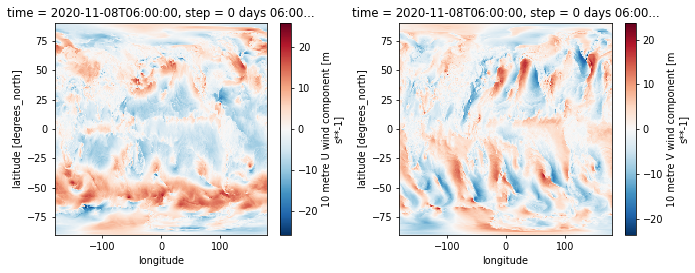

In [237]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
ds.u10.plot(ax=axes[0])
ds.v10.plot(ax=axes[1])
plt.tight_layout()
plt.show()

Interpolate

In [238]:
STEP_DEGREES = 0.1

new_lon = np.arange(ds.longitude[0], ds.longitude[-1], STEP_DEGREES)
new_lat = np.arange(ds.latitude[0], ds.latitude[-1], -STEP_DEGREES)
dsi =  ds.interp(longitude=new_lon, latitude=new_lat)

Add "is_land" data

In [239]:
mask = regionmask.defined_regions.natural_earth.land_110.mask(new_lon, new_lat)
mask = np.nan_to_num(mask, copy=False, nan=1).astype(np.bool)
mask = ~mask
dsi = dsi.assign(is_land=(("latitude", "longitude"), mask))

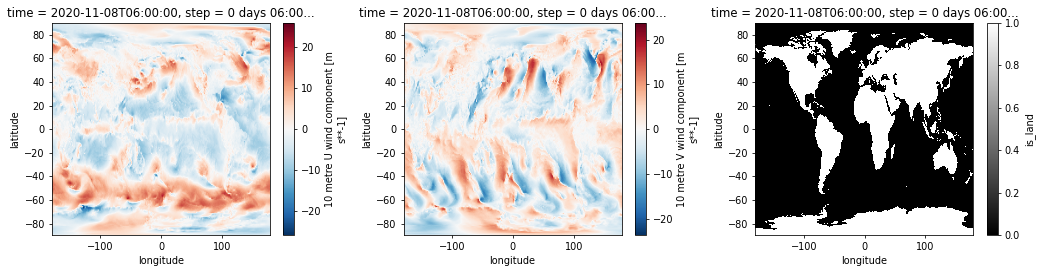

In [263]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
dsi.u10.plot(ax=axes[0])
dsi.v10.plot(ax=axes[1])
dsi.is_land.plot(ax=axes[2], cmap="gray")
plt.tight_layout()
plt.show()

# Get patch around coordinate

In [241]:
def clamp(n, smallest, largest): return max(smallest, min(n, largest))

# center = lat, lon
def get_patch(ds, center, patch_side):
    P = patch_side / 2 # TODO: how to garanty the output size ?    
    MIN_LAT = float(ds.latitude.min())
    MAX_LAT = float(ds.latitude.max())
    MIN_LON = float(ds.longitude.min())
    MAX_LON = float(ds.longitude.max())

    lat, lon = center
    northern_lat = clamp(lat + P, MIN_LAT, MAX_LAT)
    southern_lat = clamp(lat - P, MIN_LAT, MAX_LAT)
    eastern_lon = clamp(lon + P, MIN_LON, MAX_LON)
    western_lon =  clamp(lon - P, MIN_LON, MAX_LON)
    #print(northern_lat, southern_lat, eastern_lon, western_lon)    

    patch = ds.sel(
        longitude=slice(western_lon,eastern_lon), 
        latitude=slice(northern_lat, southern_lat)
    )
    
    return patch

Patches

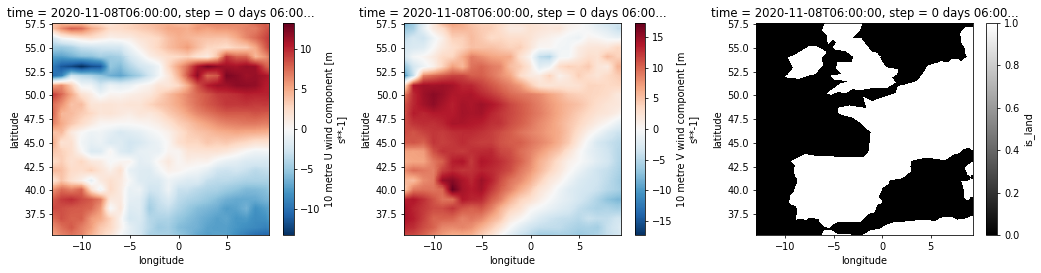

In [252]:
IMG_SIZE = 224 # We want 224*244 images
PATCH_SIZE = IMG_SIZE * STEP_DEGREES # dsi coordinates

CENTER = (first_record["lat"], first_record["lon"])
patch = get_patch(dsi, CENTER, PATCH_SIDE)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
patch.u10.plot(ax=axes[0])
patch.v10.plot(ax=axes[1])
patch.is_land.plot(ax=axes[2], cmap="gray")
plt.tight_layout()
plt.show()

Images

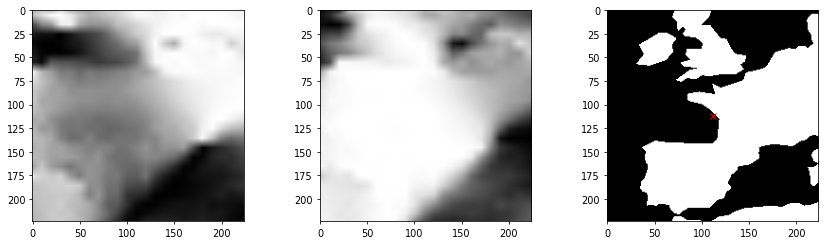

In [265]:
# Here, we use wind values normalized world-wide => is it a good or bad idea ?
u = ((patch.u_norm.values + 1) / 2) # from [-1, 1] to [0, 1] 
# u = (255 * u).astype(int) # from [0, 1] to [0, 255]
v = ((patch.v_norm.values + 1) / 2) # from [-1, 1] to [0, 1] 
is_land = patch.is_land.astype(int)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
axes[0].imshow(u, cmap='gray')
axes[1].imshow(v, cmap='gray')
axes[2].imshow(is_land, cmap='gray')

axes[2].plot(112, 112, "xr")

# Older code

In [ ]:
import numpy as np
# https://gis.stackexchange.com/questions/15545/calculating-coordinates-of-square-x-miles-from-center-point
#For example, suppose r = 10 miles and the central location is at latitude 50 degrees north, longitude 1 degree west, 
#so that (f,l) = (50,-1) degrees. Then

f, l = (50, -1) # latitude 50 degrees north, longitude 1 degree west
R = 1000 # 10 miles around

df = R/69 # Don't use this approximation near the poles
dl = R/(69*np.cos(np.deg2rad(f)))

southern_latitude = f - df
northern_latitude = f + df
western_longitude = l - dl
eastern_longitude = l + dl

#and the coordinates are (49.855,-1.225), (50.145,-1.225), (50.145, -0.775), and (49.855, -0.775)
#as you march clockwise around the square starting at its southwestern corner.

In [ ]:
def sellonlatbox(data,west,north,east,south, allow_single_point=False):
    '''
    select a rectangular box.
    if west==east and north==south, then a single point will be returned
    if allow_single_point=True, otherwise an error will be raised
    '''
    if north == south and west==east:
        if allow_single_point:
            # in this case we return a single point
            return sellonlatpoint(data,west,north)
        else:
            raise ValueError('''the requsted area is a single point 
                             (north==south and east==west)''')
    
    if north < south:
        raise ValueError('north ({}) is smaller than south ({})'.
                         format(north,south))
        
    if east < west:
        raise ValueError('west ({}) is larger than east ({})'.
                         format(west,east))
        
    # check wehther the requested point is in the domain
    lonrange = (float(data.longitude.min()), float(data.longitude.max()))
    if ( west < lonrange[0] or west > lonrange[1] or
         east < lonrange[0] or east > lonrange[1] ):
        raise ValueError('''the requested lon extend {} to {} is outside 
                         the range of the
                         dataset {}'''.format(west,east,lonrange))
    
    latrange = (float(data.latitude.min()), float(data.latitude.max()))
    if ( north < latrange[0] or north > latrange[1] or
         south < latrange[0] or south > latrange[1] ):
        raise ValueError('''the requested lat extend {} to {} is outside 
                         the range of the 
                         dataset {}'''.format(north,south,latrange))  
       
    # depending on whether lat is increasing or decreasing (which is 
    # different for different datasets) the indexing has to be done in 
    # a different way
    #if _lat_is_increasing(data):
    #indexers = {'longitude':slice(west,east), 'latitude':slice(south,north)}
    #else:
    indexers = {'longitude':slice(west,east), 'latitude':slice(north,south)}

    sub = data.sel(**indexers)

    return sub

In [57]:
new_lon = np.arange(ds.longitude[0], ds.longitude[-1], 0.1)
new_lat = np.arange(ds.latitude[0], ds.latitude[-1], -0.1)
dsi = ds.interp(latitude=new_lat, longitude=new_lon) # linear interpolation

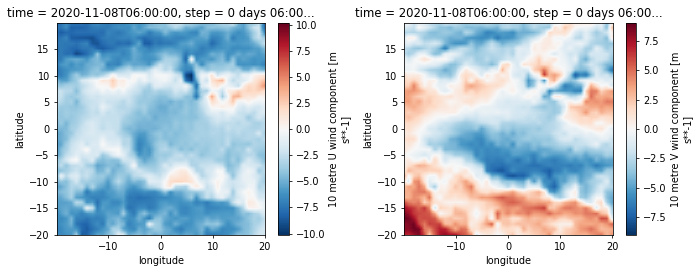

In [99]:
patch = dsi.sel(longitude=slice(-20,20), latitude=slice(20,-20))

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
patch.u10.plot(ax=axes[0])
patch.v10.plot(ax=axes[1])
plt.tight_layout()
plt.show()

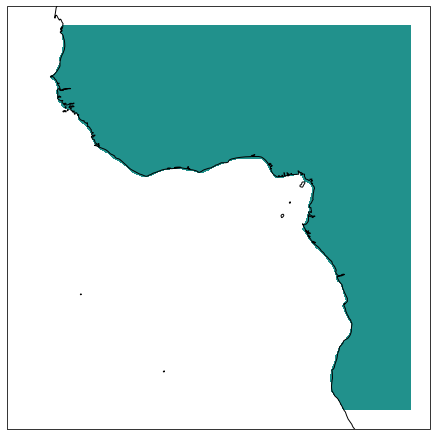

In [77]:
import cartopy.crs as ccrs
import regionmask

lon = np.arange(-20, 20, 0.1)
lat = np.arange(20, -20, -0.1)

mask = regionmask.defined_regions.natural_earth.land_110.mask(lon, lat)

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False);


In [79]:
mask

<xarray.DataArray 'region' (lat: 400, lon: 400)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 20.0 19.9 19.8 19.7 19.6 ... -19.6 -19.7 -19.8 -19.9
  * lon      (lon) float64 -20.0 -19.9 -19.8 -19.7 -19.6 ... 19.6 19.7 19.8 19.9

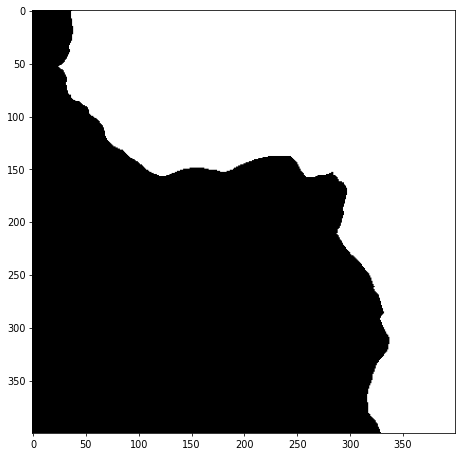

In [80]:
mask_img = mask.astype(int)
#mask_img_flip = np.flip(mask_img, 0)
#mask_img_resized = crop_center(mask_img_flip, 28, 28)
#mask_img_resized = skimage.transform.resize(mask_img_flip, (56, 56), order=0)
plt.imshow(mask_img, cmap="gray") # inverted ?!

In [81]:
mask_img.shape

(400, 400)

In [59]:

patch = dsi.sel(longitude=slice(western_longitude,eastern_longitude), latitude=slice(northern_latitude,southern_latitude))

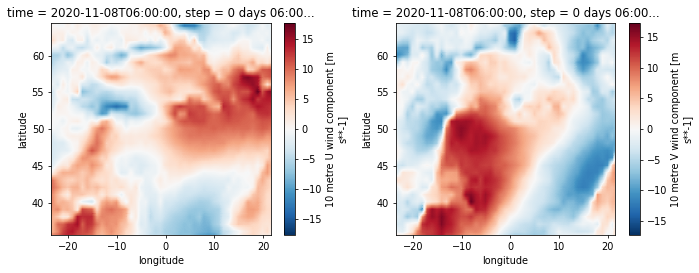

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
patch.u10.plot(ax=axes[0])
patch.v10.plot(ax=axes[1])
plt.tight_layout()
plt.show()

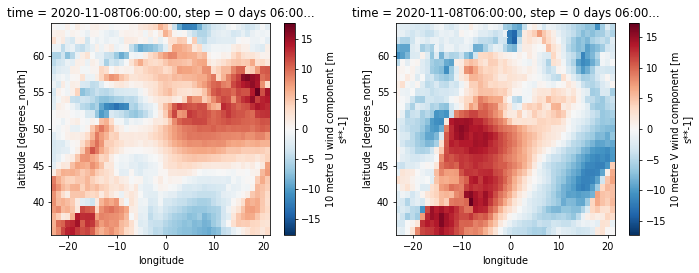

In [14]:
ds_sel = sellonlatbox(ds, western_longitude, northern_latitude, eastern_longitude, southern_latitude)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
ds_sel.u10.plot(ax=axes[0])
ds_sel.v10.plot(ax=axes[1])
plt.tight_layout()
plt.show()

In [15]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

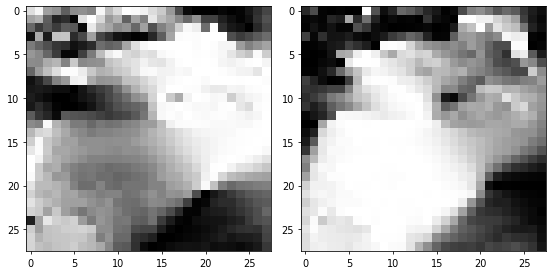

In [16]:
import matplotlib.pyplot as plt 
import skimage.transform

u = ds_sel.u10.values
v = ds_sel.v10.values

u_norm = u / (u**2 + v**2)**0.5
v_norm = v / (u**2 + v**2)**0.5

u_img = ((u_norm + 1.0) / 2) # betwen 0 and 1
v_img = ((v_norm + 1.0) / 2) # betwen 0 and 1
u_img = crop_center(u_img, 28, 28)
v_img = crop_center(v_img, 28, 28)
#u_img = skimage.transform.resize(u_img, (56, 56), order=2)
#v_img = skimage.transform.resize(v_img, (56, 56), order=2)

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(u_img, cmap="gray")
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(v_img, cmap="gray")
plt.tight_layout()
plt.show()

In [84]:
northern_latitude

64.4927536231884

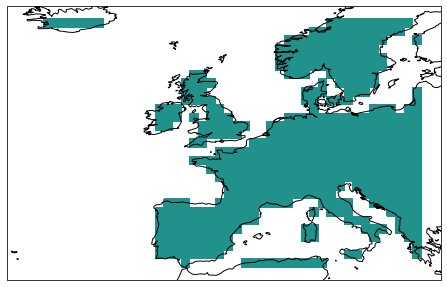

In [85]:
import cartopy.crs as ccrs
import regionmask

lon = np.arange(western_longitude, eastern_longitude, 1)
lat = np.arange(northern_latitude, southern_latitude, -1)

mask = regionmask.defined_regions.natural_earth.land_110.mask(lon, lat)

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False);

#mask = regionmask.defined_regions.natural_earth.land_110.mask_3D(ds.longitude, ds.latitude)
#plt.imshow(mask.astype(int), cmap="gray")

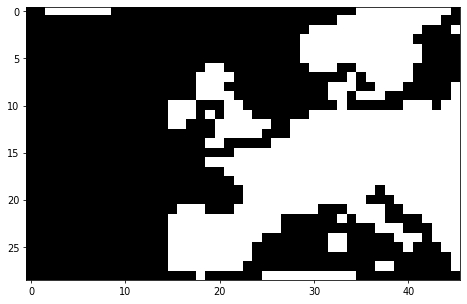

In [87]:
mask_img = mask.astype(int)
#mask_img_flip = np.flip(mask_img, 0)
#mask_img_resized = crop_center(mask_img_flip, 28, 28)
#mask_img_resized = skimage.transform.resize(mask_img_flip, (56, 56), order=0)
plt.imshow(mask_img, cmap="gray") # inverted ?!